## GuidedLDA что такое и зачем оно надо
*   Оригинал от автора библиотеки - https://medium.freecodecamp.org/how-we-changed-unsupervised-lda-to-semi-supervised-guidedlda-e36a95f3a164
*   Репозиторий - https://github.com/vi3k6i5/GuidedLDA
*   Основная работа, которую использовали для создания GuidedLDA - http://www.umiacs.umd.edu/user.php?path=jags/pdfs/GuidedLDA.pdf
* хороший пример использования GuidedLDA - https://github.com/CryptoCompareLTD/research/tree/4bd13b3a8fe7b9d6a891b8d240243695164cd58a/LDA


**Ключевое отличие от LDA**: можно усилить необходимые топики или разделить схожие, если корпус текстов не большой - при инициализации усиливаем какой-либо топик (см. параметр seed_confidence)

In [0]:
! pip install guidedlda
! pip install gensim
! pip install stop_words

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 2014-12-rbc.ru.csv to 2014-12-rbc.ru.csv
User uploaded file "2014-12-rbc.ru.csv" with length 22864554 bytes


In [42]:
import nltk
import re
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
import guidedlda
import warnings
import stop_words
import matplotlib.pyplot as plt



from nltk.corpus import stopwords
from stop_words import get_stop_words
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from gensim.utils import simple_preprocess
from nltk.tokenize import RegexpTokenizer
from gensim.models import CoherenceModel, LdaModel
from gensim.corpora import Dictionary
from stop_words import get_stop_words
from gensim import matutils
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

nltk.download('stopwords') 
stemmer = SnowballStemmer('russian')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
data = pd.read_csv('2014-12-rbc.ru.csv', sep=',', encoding='utf-8')
data.columns = ['URL','date','topics','title','text']

In [6]:
data.head()

,URL,date,topics,title,text
0,http://top.rbc.ru/politics/01/12/2014/547bb1f8...,2014-12-01 00:11:32,NaN,ДНР и ЛНР просят заменить украинские банки абх...,До начала вооруженного конфликта в Донбассе ра...
1,http://www.rbc.ru/rbcfreenews/547bb630cbb20f09...,2014-12-01 00:28:34,NaN,Приморские города Крыма получат установки по о...,Приморские города Крыма получат установки по о...
2,http://www.rbc.ru/rbcfreenews/547bbd6dcbb20f53...,2014-12-01 00:59:25,NaN,Швейцарцы проголосовали против наращивания зол...,Граждане Швейцарии не поддержали на прошедшем ...
3,http://top.rbc.ru/economics/01/12/2014/547bc22...,2014-12-01 01:19:44,NaN,Стоимость барреля нефти опустилась ниже 69 дол...,Стоимость барреля нефти опустилась ниже $69\nА...
4,http://www.rbc.ru/rbcfreenews/547bc4bbcbb20fbc...,2014-12-01 01:30:36,NaN,На северо-востоке Подмосковья в ДТП погибли че...,На северо-востоке Подмосковья в дорожно-трансп...


In [0]:
def clean_text(text, russian_words_only: bool = False, remove_stop: bool = True):

    text = str(text).lower()
    if russian_words_only:
        text = re.sub("[^а-я]", ' ', str(text))
        text = text.strip()

    else:
        text = re.sub('-\s\r\n\|-\s\r\n|\r\n|[«»]|[""]|[><]"[\[]]|//"', '', text)
        text = re.sub('[«»]|[""]|[><]"[\[]]"', '', text)
        text = re.sub('[0-9]|[-.,:;_%©?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|"|–|—|', ' ', text)
        text = re.sub(r'\r\n\t|\n|\\s|\r\t|\\n', ' ', text)
        text = re.sub(r'[\xad]|[\s+]', ' ', text)
        text = re.sub('ё', 'е', text.strip())

    if remove_stop:
        text = remove_stopwords(text)

    return text

def remove_stopwords(text):
    stopword_ru = stopwords.words('russian')
    stopword_ru.append('м')
    stopword_ru.append('это')
    stopword_ru.append('по')
    stopword_ru.append('также')
    

    text = [w for w in text.split() if w not in stopword_ru]

    return text

In [0]:
 def normalize(text : list, simple_tokenize: bool = False, return_tokenized: bool = False, lemma = 'nltk'):
        if simple_tokenize:
            words = text.split()
        else:
            words = text

        if lemma == 'nltk':
            lemmatizer = WordNetLemmatizer()
            lemmatized = [lemmatizer.lemmatize(w) for w in words]
        elif lemma == 'pymorphy':
            lemmatized = lemmatize_pymorph(words)
        elif lemma == 'mystem':
            mystem = Mystem()
            lemmatized = mystem.lemmatize(words)

        if not return_tokenized:
            return ' '.join(lemmatized)
        else:
            return lemmatized

In [0]:
data['cleaned_text'] = data['text'].apply(clean_text)
data['token_text'] = data['cleaned_text'].apply(lambda x: normalize(x, return_tokenized=True))

In [13]:
data.head()

,URL,date,topics,title,text,cleaned_text,token_text
0,http://top.rbc.ru/politics/01/12/2014/547bb1f8...,2014-12-01 00:11:32,NaN,ДНР и ЛНР просят заменить украинские банки абх...,До начала вооруженного конфликта в Донбассе ра...,"[начала, вооруженного, конфликта, донбассе, ра...","[начала, вооруженного, конфликта, донбассе, ра..."
1,http://www.rbc.ru/rbcfreenews/547bb630cbb20f09...,2014-12-01 00:28:34,NaN,Приморские города Крыма получат установки по о...,Приморские города Крыма получат установки по о...,"[приморские, города, крыма, получат, установки...","[приморские, города, крыма, получат, установки..."
2,http://www.rbc.ru/rbcfreenews/547bbd6dcbb20f53...,2014-12-01 00:59:25,NaN,Швейцарцы проголосовали против наращивания зол...,Граждане Швейцарии не поддержали на прошедшем ...,"[граждане, швейцарии, поддержали, прошедшем, р...","[граждане, швейцарии, поддержали, прошедшем, р..."
3,http://top.rbc.ru/economics/01/12/2014/547bc22...,2014-12-01 01:19:44,NaN,Стоимость барреля нефти опустилась ниже 69 дол...,Стоимость барреля нефти опустилась ниже $69\nА...,"[стоимость, барреля, нефти, опустилась, ниже, ...","[стоимость, барреля, нефти, опустилась, ниже, ..."
4,http://www.rbc.ru/rbcfreenews/547bc4bbcbb20fbc...,2014-12-01 01:30:36,NaN,На северо-востоке Подмосковья в ДТП погибли че...,На северо-востоке Подмосковья в дорожно-трансп...,"[северо, востоке, подмосковья, дорожно, трансп...","[северо, востоке, подмосковья, дорожно, трансп..."


### Готовим Doc-term матрицу

In [14]:
processed_docs = data['token_text']
dictionary = gensim.corpora.Dictionary(processed_docs)

def bow_iterator(docs, dictionary):
    for doc in docs:
        yield dictionary.doc2bow(doc)

def get_term_matrix(docs, dictionary):
    bow = bow_iterator(docs, dictionary)
    X = np.transpose(matutils.corpus2csc(bow).astype(np.int64))
    return X

doc_term_matrix = get_term_matrix(processed_docs, dictionary)
vocab = list(dictionary.values())
word2id = dict((v, idx) for idx, v in enumerate(vocab))

print(doc_term_matrix.toarray())

[[1 1 2 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 2 1]]


### GuidedLDA без выделения топиков

In [15]:
model = guidedlda.GuidedLDA(n_topics=7, n_iter=100, random_state=7, refresh=20)
model.fit(doc_term_matrix)

INFO:guidedlda:n_documents: 7076
INFO:guidedlda:vocab_size: 93058
INFO:guidedlda:n_words: 1162165
INFO:guidedlda:n_topics: 7
INFO:guidedlda:n_iter: 100
INFO:guidedlda:<0> log likelihood: -14550071
INFO:guidedlda:<20> log likelihood: -11724913
INFO:guidedlda:<40> log likelihood: -11485563
INFO:guidedlda:<60> log likelihood: -11400639
INFO:guidedlda:<80> log likelihood: -11357469
INFO:guidedlda:<99> log likelihood: -11334031


In [16]:
topic_word = model.topic_word_
n_top_words = 10

for i, topic_dist in enumerate(topic_word):
  topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
  print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: россии украины заявил декабря президент сказал президента сша года глава
Topic 1: врезка голы й матче чемпионов тура лиги гол матч мяч
Topic 2: россии россия мира очень место подборов года году сочи кубка
Topic 3: россии спорт чемпионат команды сборной слова чемпионата динамо тренер приводит
Topic 4: руб года млрд декабря цб россии цены рубля банка году
Topic 5: декабря суд человек года сообщает суда москвы время данным который
Topic 6: года компании млн рбк году тыс руб млрд компания представитель


#### Видно, что топики 1,2,3 - спорт, 4,6 - экономика, 0,5 - политика. Попробуем явно выделить топики.

### GuidedLDA с выделением топиков

In [0]:
seed_topics_list = [['украина', 'донецк','луганск', 'порошенко', 'яценюк', 'киев', 'конфликт','донбасс'],
    ['футбол', 'хоккей', 'уефа', 'рфс', 'кхл', 'биатлон', 'волейбол', 'тренер', 'команда', 'баскетбол', 'фифа', 'нба'],
    ['нато', 'оон', 'евросоюз', 'рф', 'сша', 'китай', 'европарламент','ес', 'террорист','мид', 'иммигрант'],
                    ['газпром', 'нефть', 'роснефть', 'добыча', 'запас', 'газ', 'трубопровод', 'поток'],
               ['полиция', 'митинг', 'область', 'регион', 'губернатор',
                'выборы','дума','дорога','повестка','прокуратура','указ', 'законопроект'],
               ['google', 'apple','microsoft', 'гейтс', 'маск', 'tesla', 'интернет', 'портал', 'вконтакте','одноклассники','дуров', 'mail'],
                    ['рубль', 'курс', 'евро','юань','доллар', 'банк']]

topic_names = ['Донецк-Луганск', 'Спорт', 'Мировая политика', 'Нефть',
               'Внутренняя политика', 'Tech_Интернет', 'Экономика']

n_topics = len(topic_names)

In [0]:
model1 = guidedlda.GuidedLDA(n_topics, n_iter=100,random_state=7, refresh=20)

In [0]:
seed_topics = {}

for t_id, st in enumerate(seed_topics_list):
  for word in st:
    try:
      seed_topics[word2id[word]] = t_id
    except:
      print(f'не найдено слово {word}')
      seed_topics_list[t_id].remove(word)
      pass

In [20]:
model1.fit(doc_term_matrix, seed_topics, seed_confidence=0.15)

INFO:guidedlda:n_documents: 7076
INFO:guidedlda:vocab_size: 93058
INFO:guidedlda:n_words: 1162165
INFO:guidedlda:n_topics: 7
INFO:guidedlda:n_iter: 100
INFO:guidedlda:<0> log likelihood: -14550071
INFO:guidedlda:<20> log likelihood: -11724913
INFO:guidedlda:<40> log likelihood: -11485563
INFO:guidedlda:<60> log likelihood: -11400639
INFO:guidedlda:<80> log likelihood: -11357469
INFO:guidedlda:<99> log likelihood: -11334031


In [21]:
topic_word = model1.topic_word_
n_top_words = 10

for topic_id, topic in enumerate(model1.topic_word_):
  print("Topic {}:".format(topic_names[topic_id]))
  topic_words = np.array(vocab)[np.argsort(topic)][:-(n_top_words+1):-1]
  print(" ".join(topic_words))

Topic Донецк-Луганск:
россии украины заявил декабря президент сказал президента сша года глава
Topic Спорт:
врезка голы й матче чемпионов тура лиги гол матч мяч
Topic Мировая политика:
россии россия мира очень место подборов года году сочи кубка
Topic Нефть:
россии спорт чемпионат команды сборной слова чемпионата динамо тренер приводит
Topic Внутренняя политика:
руб года млрд декабря цб россии цены рубля банка году
Topic Tech_Интернет:
декабря суд человек года сообщает суда москвы время данным который
Topic Экономика:
года компании млн рбк году тыс руб млрд компания представитель


### Топики "Донецк-Луганск", "Нефть", "Tech_Интернет" получились с неоднозначными ключевыми словами. Посмотрим на то, к какому топику относится каждый документ.

In [0]:
doc_topic = model1.transform(doc_term_matrix)

In [23]:
highest_topic = []
for i in range(len(doc_topic)):
    match = doc_topic[i].argmax()
    highest_topic.append(match)
len(highest_topic)

7076

In [24]:
HT = pd.DataFrame(highest_topic, columns = ['HighTopicIndex'])
lookuptable = pd.DataFrame(topic_names, columns = ['topic'])
lookuptable['HighTopicIndex'] = lookuptable.index
prep2 = pd.merge(HT, lookuptable, on = 'HighTopicIndex', how = 'left')
prep = pd.concat([data, prep2], axis = 1)
prep[['date','text','HighTopicIndex','topic']].head(10)

,date,text,HighTopicIndex,topic
0,2014-12-01 00:11:32,До начала вооруженного конфликта в Донбассе ра...,0,Донецк-Луганск
1,2014-12-01 00:28:34,Приморские города Крыма получат установки по о...,0,Донецк-Луганск
2,2014-12-01 00:59:25,Граждане Швейцарии не поддержали на прошедшем ...,6,Экономика
3,2014-12-01 01:19:44,Стоимость барреля нефти опустилась ниже $69\nА...,4,Внутренняя политика
4,2014-12-01 01:30:36,На северо-востоке Подмосковья в дорожно-трансп...,5,Tech_Интернет
5,2014-12-01 01:57:04,"В СКР утверждают, что причиной преступления ст...",5,Tech_Интернет
6,2014-12-01 02:24:03,На итоги парламентских выборов в Молдавии могл...,0,Донецк-Луганск
7,2014-12-01 02:51:05,"Социалистическая партия, занимающая первое мес...",0,Донецк-Луганск
8,2014-12-01 02:59:15,Российскую спутниковую группировку пополнил вт...,0,Донецк-Луганск
9,2014-12-01 03:18:54,Член комитета по транспорту Государственной ду...,5,Tech_Интернет


## Немного визуализации

In [0]:
def display_assignment(model, topic_names):
        assignments = [sum(m) for m in model.doc_topic_.T]
        plt.pie(assignments, labels = topic_names)
        plt.show()

In [0]:
def example_documents(data, model, topic_name, threshold= 0.7):
  """
  Документы, относящие сильнее всего к топику  
  """
  topic = topic_names.index(topic_name)
  docs = []
  print("Топик: {}".format(topic_name))
  for i, doc_dist in enumerate(model.doc_topic_):
    if doc_dist[topic]>0.7:
      #print('1')
      docs.append(data.text[i])
  for doc in docs:
    print(doc + '\n')

In [0]:
def separate_date(timestamp):
    return pd.to_datetime(timestamp)

### Возьмем только основные топики для документов

In [0]:
thresh = 0.1 
def define_allocation(allocation):
    if allocation < thresh:
        return 0
    else:
        return allocation

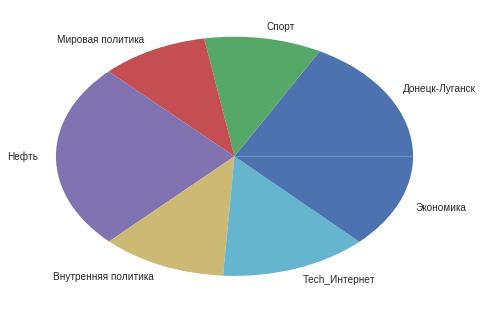

In [30]:
display_assignment(model1, topic_names)

In [31]:
example_documents(data, model1, 'Спорт', threshold=0.1)

Топик: Спорт
13-й тур чемпионата Англии по футболу среди команд Премьер-лиги получился богатым на важные события. Футболисты «Челси» подарили шанс конкурентам, оступившись на «Стэдиум оф Лайт». «Манчестер Сити» сделал всё, чтобы развенчать мифы о «Саутгемптоне» - дерзком претенденте на финиш в лигочемпионской зоне. «Арсенал», «Манчестер Юнайтед» и «Ливерпуль» показали, что их ещё рано списывать со счетов. А «Тоттенхэм» в принципиальном матче переиграл «Эвертон».
Футболисты «Куинз Парк Рейнджерс» в битве за выживание взяли верх над «Лестером». И теперь уже «лисы» замыкают турнирную таблицу АПЛ. Но там, в подвалах турнирной таблицы, сохраняется такая плотность, что 20-е и 14-е места разделяют всего три очка.
Чёрный кот им перешёл дорогу
Поездка на «Стэдиум оф Лайт» получилась для «Челси» очень тяжелой. Хозяева не скрывали, что в этот день во главу угла они поставят надёжную игру в обороне. «Чёрные коты» безропотно отдали сопернику территорию, но пытались удерживать «синих» на почтительно

TypeError: ignored

In [0]:
# Смотрим распределение топиков по дате публикации
df = prep[['topic', 'date']]


df_allocations = pd.DataFrame(model1.doc_topic_, columns = topic_names) 
df = pd.concat([df, df_allocations], axis=1)

df['date'] = df['date'].apply(separate_date)
for name in topic_names:
    df[name] = df[name].apply(define_allocation)
    
df_publications = df.groupby('date').sum().groupby(pd.Grouper(freq='1d')).sum()

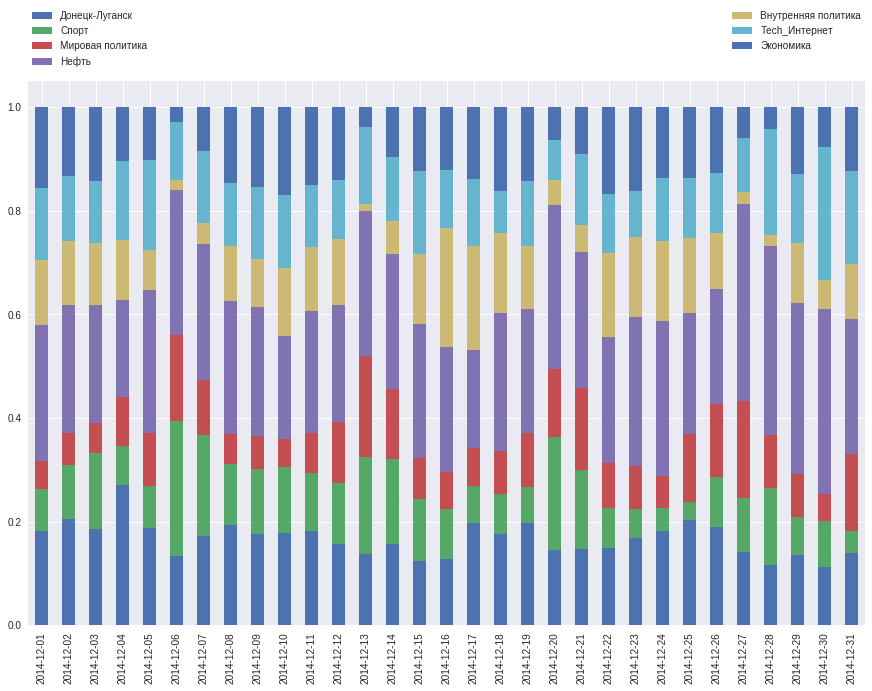

In [34]:
fig, ax = plt.subplots(figsize = (15, 10))
df_publications.divide(df_publications.sum(axis=1), axis=0).plot(kind='bar', stacked=True, ax=ax)
legend = ax.legend(loc='upper center', shadow=True)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
ax.set_xticklabels(df_publications.index.strftime("%Y-%m-%d"))
ax.set_xlabel("");

In [0]:
%%time
doc_term_matrix_p = [dictionary.doc2bow(doc) for doc in data['token_text'].values]
ldamodel = LdaModel(doc_term_matrix_p, num_topics=7, id2word = dictionary, passes=10)

In [0]:
%%time
perplexity = ldamodel.log_perplexity(doc_term_matrix_p)
coherence_model_lda = CoherenceModel(model=ldamodel, texts=data['token_text'].values, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

In [44]:
print(f'Perplexity: {perplexity}')
print(f'Coherence Score: {coherence_lda}')

Perplexity: -9.491700573809938
Coherence Score: 0.5160141244602763
